# Test the performance of the model

## Occurrence of symmetry equivalent structures

### Binary Quadratic Model

In [1]:
from quantum_computing_functions import *
from quantum_computing_postprocessing import *

import numpy as np
import pandas as pd

from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.io.ase import AseAtomsAdaptor

from ase.visualize import view

In [2]:
from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
import copy

lattice = np.array([[ 1.233862, -2.137112,  0.      ],
                   [ 1.233862,  2.137112,  0.      ],
                   [ 0.      ,  0.      ,  8.685038]])

graphene = Structure(lattice, species=['C','C'], coords=[[2/3, 1/3, 0. ],[1/3, 2/3, 0.]])
graphene = SpacegroupAnalyzer(graphene).get_conventional_standard_structure()

n_supercell = 3
scaling_matrix = np.identity(3)*n_supercell
scaling_matrix[2][2] = 1
graphene_supercell = copy.deepcopy(graphene)
graphene_supercell.make_supercell(scaling_matrix)
graphene_supercell.num_sites

18

### Tests:
- chain_break_fracion, number of energy values, number of occurences (1v) 
- vs
- num_cycles, chain strength, cell size

# Loop

In [3]:
#for lagrange in [10,50,100,500,1000]:   
#for num_reads in [100,500,1000,1500,2000,2500]:   
for vac in [1,2,3]:
#for r in [10]:
    #for ratio in np.arange(1.1,2.6,0.2):
    structure = graphene_supercell
    use_coord = False
    num_vacancies= vac
    weight_1 = 1
    weight_2 = 0
    lagrange =  weight_1 * 2
    num_reads = 1000
    file_path = 'data/chain_strength'
    file_name = 'graphene'
    remove_broken_chains = False
    #chain_strength = None

    #print(lagrange,weight_1)
    bqm = build_quadratic_model(structure,use_coord=use_coord,weight_1=weight_1,weight_2=weight_2,
                                 lagrange=lagrange, num_vacancies=num_vacancies)

    #cqm = build_constrained_quadratic_model(structure,use_coord = use_coord, num_vacancies = num_vacancies, 
                      #weight_1=weight_1, weight_2 = weight_2, lagrange = lagrange)
    for chain_strength in [1,11]:
        sampleset = run_anneal(bqm,dataframe = False, num_reads=num_reads, 
                                               return_config_E=False,remove_broken_chains=remove_broken_chains,
                              chain_strength=chain_strength)

        #dataframe = run_anneal(cqm,num_reads=num_reads, return_config_E=False,remove_broken_chains=remove_broken_chains)


        #save cqm
        '''save_json(structure,dataframe,cqm,use_coord=use_coord, num_vacancies=num_vacancies, 
              weight_1=weight_1, weight_2=weight_2, lagrange=lagrange, num_reads=num_reads,
              remove_broken_chains = remove_broken_chains,
              file_path=file_path, file_name=file_name, save_qubo=False)
        '''

        #save bqm
        save_json(structure,sampleset,bqm,use_coord=use_coord, num_vacancies=num_vacancies, 
          weight_1=weight_1, weight_2=weight_2, lagrange=lagrange, num_reads=num_reads,
          remove_broken_chains = remove_broken_chains,
          file_path=file_path, file_name=file_name, chain_strength=chain_strength)
    

Unconstrained quadratic model + contraints used


KeyError: 'embedding_context'

In [6]:
#INCLUDE BROKEN CHAINS
import os

directory = 'data/test/'
#directory = 'data/chain_strength'

dataframes = []

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f) and f.endswith(".json") and 'bqm' in f:
        #print(f)
        df, param = load_json(f,return_param = True, return_qubo = False)        
        param = param.transpose()
        n_vac = param['num_vacancies'].values[0]
        n_atoms = param['N atoms'].values[0]
        param['broken_chains'] = find_ratio_broken_chains(df)   
        param['ratio_feasible'] = find_ratio_feasible(df,param['num_vacancies'].values[0], remove_broken_chains=False)
        param['energy_distribution_all'] = ', '.join(str(x) for x in find_energy_distribution(df)[0])
        param['multiplicity_all'] = ', '.join(str(x) for x in find_energy_distribution(df)[1])        
        param['energy_distribution'] = ', '.join(str(x) for x in find_energy_distribution(df, only_feasible=True, vacancies=param['num_vacancies'].values[0])[0])
        #param['num_broken_bonds'] = ', '.join(str(x) for x in find_num_broken_bonds(dataframe, remove_broken_chains = True, only_feasible = True, vacancies = param['num_vacancies'].values[0]))
        param['multiplicity'] = ', '.join(str(x) for x in find_energy_distribution(df, only_feasible=True, vacancies=param['num_vacancies'].values[0])[1])
        param['ratio l/w'] =  param['lagrange'] / param['weight_1'] 
        param['vacancies'] = ', '.join(str(x) for x in find_vacancy_distribution(df)[0])
        param['vacancies mult'] = ', '.join(str(x) for x in find_vacancy_distribution(df)[1])
        
        
        #print(energy_distribution(df, only_feasible=True, vacancies=n_vac))
        '''if energy_distribution(df, only_feasible=True, vacancies=n_vac)[0][0] == -(-1 - n_vac*2+n_atoms*1.5):
            param['min_found'] = True
        else:
            param['min_found'] = False'''
        if 'chain_strength' not in param:
            param['chain_strength'] = -1
        #print(param['chain_strength'])
        if param['chain_strength'].all() == None:
            param['chain_strength'] = -1
        dataframes.append(param)

df_results = pd.concat(dataframes)

In [7]:
df_results

,date_time,time_stamp,structure,N atoms,model,use_coord,num_vacancies,weight_1,weight_2,lagrange,...,qpu_anneal_time_per_sample,broken_chains,ratio_feasible,energy_distribution_all,multiplicity_all,energy_distribution,multiplicity,ratio l/w,vacancies,vacancies mult
Values,"07/21/2022, 09:55:31",1658397331,C18,18,bqm,False,3,1,0,10,...,20.0,0.070,0.536,"-20.0, -19.0, -18.0, -12.0, -11.0, -8.0, -7.0,...","41, 248, 247, 3, 24, 23, 102, 197, 92, 1, 1, 5...","-20.0, -19.0, -18.0","41, 248, 247",10.0,"1, 2, 3, 4, 5, 6","1, 27, 376, 380, 21, 1"
Values,"07/21/2022, 12:25:46",1658406346,C18,18,bqm,False,3,10,0,80,...,20.0,0.249,0.577,"-200.0, -190.0, -180.0, -140.0, -130.0, -100.0...","47, 259, 271, 11, 45, 18, 99, 154, 76, 1, 2, 1...","-200.0, -190.0, -180.0","47, 259, 271",8.0,"1, 2, 3, 4, 5","1, 41, 391, 315, 19"
Values,"07/21/2022, 09:56:25",1658397385,C18,18,bqm,False,3,1,0,9,...,20.0,0.101,0.541,"-20.0, -19.0, -18.0, -13.0, -12.0, -9.0, -8.0,...","45, 239, 257, 9, 28, 15, 112, 182, 95, 2, 3, 8...","-20.0, -19.0, -18.0","45, 239, 257",9.0,"2, 3, 4, 5, 6","34, 407, 379, 17, 1"
Values,"07/21/2022, 09:54:55",1658397295,C18,18,bqm,False,3,1,0,3,...,20.0,0.169,0.675,"-20.0, -19.0, -18.0, -15.0, -14.0, -13.0, -12....","98, 352, 330, 27, 74, 84, 27, 2, 2, 3, 1","-20.0, -19.0, -18.0","98, 330, 247",3.0,"1, 2, 3, 4, 5","1, 83, 436, 197, 8"
Values,"07/21/2022, 12:07:42",1658405262,C18,18,bqm,False,3,10,0,20,...,20.0,0.223,0.666,"-200.0, -190.0, -180.0, -160.0, -150.0, -140.0...","131, 445, 296, 20, 47, 45, 13, 2, 1","-200.0, -190.0, -180.0","86, 284, 296",2.0,"1, 2, 3, 4, 5","5, 118, 444, 120, 3"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Values,"07/21/2022, 12:07:55",1658405275,C18,18,bqm,False,3,10,0,40,...,20.0,0.172,0.622,"-200.0, -190.0, -180.0, -170.0, -140.0, -130.0...","61, 262, 317, 40, 16, 100, 130, 61, 1, 2, 2, 6, 2","-200.0, -190.0, -180.0","61, 262, 299",4.0,"1, 2, 3, 4, 5","1, 43, 401, 285, 12"
Values,"07/21/2022, 11:29:37",1658402977,C18,18,bqm,False,2,1,0,5,...,20.0,0.104,0.557,"-22.0, -21.0, -19.0, -15.0, -14.0, -13.0, 3.0,...","98, 459, 31, 32, 161, 201, 10, 7, 1","-22.0, -21.0","98, 459",5.0,"1, 2, 3, 4","17, 179, 293, 18"
Values,"07/19/2022, 16:32:21",1658248341,C18,18,bqm,False,3,1,0,10,...,20.0,0.133,0.557,"-20.0, -19.0, -18.0, -12.0, -11.0, -8.0, -7.0,...","34, 237, 286, 5, 21, 20, 106, 183, 94, 3, 5, 5, 1","-20.0, -19.0, -18.0","34, 237, 286",10.0,"2, 3, 4, 5","24, 395, 362, 14"
Values,"07/21/2022, 12:23:00",1658406180,C18,18,bqm,False,1,10,0,30,...,20.0,0.088,0.548,"-240.0, -190.0, -180.0, -80.0, -70.0, -60.0","575, 104, 305, 3, 4, 9",-240.0,548,3.0,"0, 1, 2, 3","3, 44, 157, 16"


In [479]:
#df_results= df_results[df_results['N atoms'] == 18]
df_results= df_results#[df_results['num_vacancies'] == 1]
df_all = df_results[['N atoms','num_vacancies', 'weight_1', 'weight_2', 'lagrange','ratio l/w', 'num_reads',
          'broken_chains','ratio_feasible', 
            'energy_distribution', 'multiplicity','chain_strength']]#.sort_values(['num_vacancies'])
#df_all[df_all['num_vacancies'] == 1].sort_values(by='ratio_feasible')
df_all[df_all['weight_1'] == 10].sort_values(by='ratio l/w')
#df_all

,N atoms,num_vacancies,weight_1,weight_2,lagrange,ratio l/w,num_reads,broken_chains,ratio_feasible,energy_distribution,multiplicity,chain_strength
Values,18,1,10,0,10,1.0,1000,0.059,0.546,-240.0,546,108.611401
Values,18,1,10,0,10,1.0,1000,0.039,0.542,-240.0,542,108.611401
Values,18,1,10,0,10,1.0,1000,0.019,0.541,-240.0,541,108.611401
Values,18,1,10,0,10,1.0,1000,0.020,0.549,-240.0,549,108.611401
Values,18,3,10,0,20,2.0,1000,0.223,0.666,"-200.0, -190.0, -180.0","86, 284, 296",224.01973
Values,18,1,10,0,20,2.0,1000,0.317,0.522,-240.0,522,224.01973
Values,18,2,10,0,20,2.0,1000,0.297,0.648,"-220.0, -210.0","201, 447",224.01973
Values,18,2,10,0,40,4.0,1000,0.341,0.595,"-220.0, -210.0","166, 429",456.658519
Values,18,3,10,0,40,4.0,1000,0.172,0.622,"-200.0, -190.0, -180.0","61, 262, 299",456.658519
Values,18,1,10,0,40,4.0,1000,0.067,0.458,-240.0,458,456.658519


In [2]:
a = load_json('./data/test/graphene_C18_bqm_v2_cF_w11_w20_l10_r1000_t0_1658248063.json')[0]
#np.sum(a['num_occurrences'].to_numpy()[np.where(np.sum(a.iloc[:,0:18].to_numpy(),axis=1) == 16)[0]])
#np.unique(18-np.sum(a.iloc[:,0:18].to_numpy(),axis=1), return_counts=True)

In [3]:
find_vacancy_distribution(a)

(array([1, 2, 3, 4]), array([ 13, 182, 311,  37]))

In [17]:
a = load_json('./data/test/graphene_C18_bqm_v1_cF_w11_w20_l1.1_r1000_t0_1658408290.json')[2]
#np.sum(a['num_occurrences'].to_numpy()[np.where(np.sum(a.iloc[:,0:18].to_numpy(),axis=1) == 17)[0]])


array([-36,   2,   2,   2,   2,   2,   2,   2,   2,   1,   1,   2,   2,
         2,   2,   1,   2,   2,   0, -36,   2,   2,   2,   2,   2,   2,
         2,   2,   1,   1,   2,   2,   2,   2,   1,   2,   0,   0, -36,
         2,   2,   2,   2,   2,   2,   1,   2,   1,   2,   2,   2,   2,
         2,   1,   0,   0,   0, -36,   2,   2,   2,   2,   2,   1,   2,
         2,   1,   1,   2,   2,   2,   2,   0,   0,   0,   0, -36,   2,
         2,   2,   2,   2,   1,   2,   2,   1,   1,   2,   2,   2,   0,
         0,   0,   0,   0, -36,   2,   2,   2,   2,   2,   1,   1,   2,
         1,   2,   2,   2,   0,   0,   0,   0,   0,   0, -36,   2,   2,
         2,   2,   2,   1,   2,   2,   1,   1,   2,   0,   0,   0,   0,
         0,   0,   0, -36,   2,   2,   2,   2,   2,   1,   2,   2,   1,
         1,   0,   0,   0,   0,   0,   0,   0,   0, -36,   2,   2,   2,
         2,   2,   1,   1,   2,   1,   0,   0,   0,   0,   0,   0,   0,
         0,   0, -36,   2,   2,   2,   2,   2,   2,   2,   2,   

## $\alpha$ , $\gamma$ ratio

### weight_1 = 1

In [10]:
df_results['vacancies'].to_list()

['1, 2, 3, 4, 5, 6',
 '1, 2, 3, 4, 5',
 '2, 3, 4, 5, 6',
 '1, 2, 3, 4, 5',
 '1, 2, 3, 4, 5',
 '1, 2, 3, 4, 5',
 '2, 3, 4, 5',
 '0, 1, 2, 3',
 '1, 2, 3, 4, 5',
 '2, 3, 4, 5',
 '1, 2, 3, 4',
 '0, 1, 2, 3',
 '0, 1, 2, 3',
 '0, 1, 2, 3',
 '0, 1, 2',
 '0, 1, 2, 3',
 '1, 2, 3, 4, 5',
 '0, 1, 2, 3',
 '0, 1, 2, 3, 4',
 '2, 3, 4, 5',
 '0, 1, 2, 3',
 '2, 3, 4, 5',
 '0, 1, 2',
 '0, 1, 2, 3',
 '0, 1, 2, 3',
 '2, 3, 4, 5',
 '0, 1, 2, 3, 4',
 '0, 1, 2, 3',
 '1, 2, 3, 4, 5',
 '1, 2, 3, 4',
 '1, 2, 3, 4, 5',
 '1, 2, 3, 4',
 '1, 2, 3, 4, 5',
 '1, 2, 3, 4, 5',
 '1, 2, 3, 4, 5',
 '0, 1, 2, 3',
 '0, 1, 2, 3',
 '1, 2, 3, 4, 5',
 '2, 3, 4, 5',
 '1, 2, 3, 4, 5',
 '1, 2, 3, 4, 5',
 '1, 2, 3, 4, 5',
 '1, 2, 3, 4',
 '0, 1, 2, 3, 4',
 '0, 1, 2, 3',
 '1, 2, 3, 4',
 '0, 1, 2, 3',
 '1, 2, 3, 4',
 '1, 2, 3, 4',
 '0, 1, 2, 3',
 '2, 3, 4, 5',
 '2, 3, 4, 5',
 '1, 2, 3, 4, 5, 6',
 '0, 1, 2, 3',
 '1, 2, 3, 4, 5',
 '0, 1, 2, 3',
 '1, 2, 3, 4',
 '0, 1, 2, 3',
 '1, 2, 3, 4',
 '0, 1, 2, 3',
 '0, 1, 2, 3, 4',
 '0, 1, 2, 3, 4'

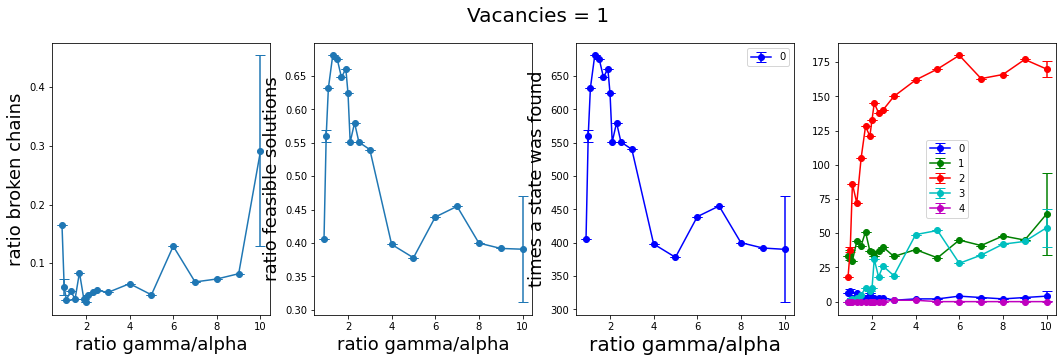

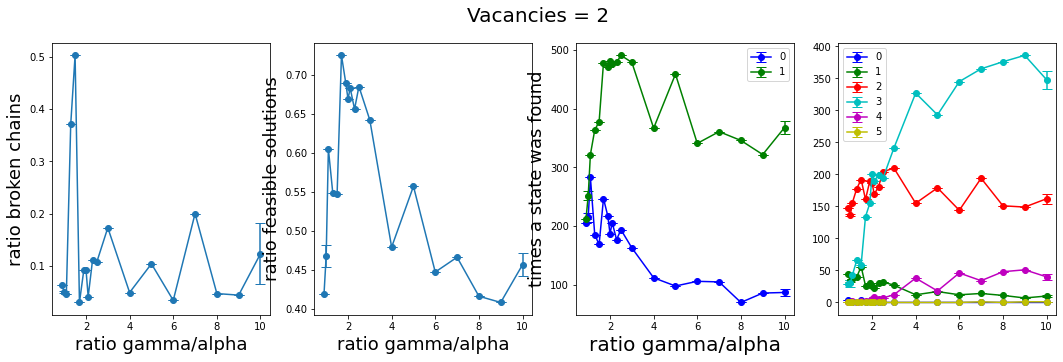

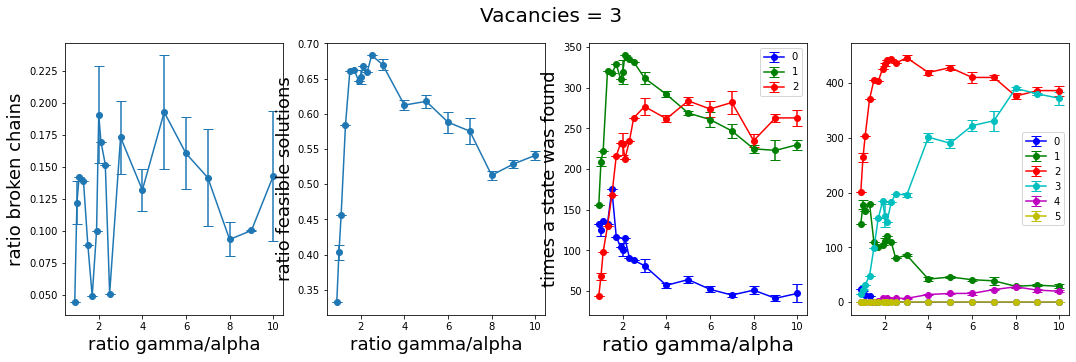

In [27]:
#FEASIBLE
import matplotlib.pyplot as plt

color = ['b','g','r','c','m','y','k','tab:orange']


for vac in [1,2,3]:
    df_all = df_results[df_results['num_vacancies'] == vac]
    df_all = df_all[df_all['weight_1'] == 1.]
    df_mean = df_all[df_all['weight_1'] == 1.].groupby('ratio l/w').mean()
    fig, axs = plt.subplots(1,4,figsize=(18, 5), sharey=False)
    fig.suptitle('Vacancies = %s'%vac, fontsize=20)
    
    x = df_mean.index.values

    y1 = df_mean['broken_chains'].to_numpy()
    y2 = df_mean['ratio_feasible'].to_numpy()

    y3 = []
    y4 = []
    error_y3 = []
    error_y4 = []
    error_bc = []
    error_rf = []
    for n,k in enumerate(x):
        
        df_tmp = df_all[df_all['ratio l/w'] == k]
        
        #display(df_tmp)
        
        #df_tmp = df_all[df_all['chain_strength'] == k]
        energies = []
        for i in df_all['energy_distribution']:
            energies.extend([float(x) for x in i.split(',')])         
        all_energies = np.unique(np.array(energies))
        labels = [str(x) for x in range(len(all_energies))]
        dist_average = np.array([0]*len(all_energies))
        all_dist = []
        
        vacancies = []
        for i in df_all['vacancies']:
            vacancies.extend([float(x) for x in i.split(',')])         
        all_vacancies = np.unique(np.array(vacancies))
        labels_vac = [str(x) for x in range(len(all_vacancies))]
        dist_vac_average = np.array([0]*len(all_vacancies))
        all_vac = []
        
        #error_bc.append(np.max(df_tmp['broken_chains'].to_numpy() - np.min(df_tmp['broken_chains'].to_numpy()))
        #error_rf.append(np.max(df_tmp['ratio_feasible'].to_numpy()) - np.min(df_tmp['ratio_feasible'].to_numpy()))
        error_bc.append(np.std(df_tmp['broken_chains'].to_numpy()))
        error_rf.append(np.std(df_tmp['ratio_feasible'].to_numpy()))
        for j in range(len(df_tmp['energy_distribution'].to_list())):
            distribution = []
            error = []
            for i in all_energies:
                v_energy = np.array([float(x) for x in df_tmp['energy_distribution'].to_list()[j].split(',')])
                v_mult = np.array([float(x) for x in df_tmp['multiplicity'].to_list()[j].split(',')])
                pos = np.where(np.round(v_energy,5) == np.round(i,5))[0]
                if len(pos) > 0:
                    distribution.append(int(v_mult[pos[0]]))
                else:
                    distribution.append(0)
            all_dist.append(distribution) 
        y3.append(np.average(np.array(all_dist),axis=0).astype(int).tolist())
        
        #error_y3.append(np.max(all_dist,axis=0)-np.min(all_dist,axis=0))
        error_y3.append(np.std(all_dist,axis=0))
        #print(y3,np.max(all_dist,axis=0)-np.min(all_dist,axis=0),np.max(all_dist,axis=0),np.min(all_dist,axis=0))
        
        
        for j in range(len(df_tmp['vacancies'].to_list())):
            vacancies = []
            error = []
            for i in all_vacancies:
                #print(i,j,len(df_tmp['energy_distribution'].to_list()))
                v_vacancies = np.array([float(x) for x in df_tmp['vacancies'].to_list()[j].split(',')])
                v_vac_mult = np.array([float(x) for x in df_tmp['vacancies mult'].to_list()[j].split(',')])
                pos = np.where(np.round(v_vacancies,5) == np.round(i,5))[0]
                if len(pos) > 0:
                    vacancies.append(int(v_vac_mult[pos[0]]))
                else:
                    vacancies.append(0)
            all_vac.append(vacancies) 
        y4.append(np.average(np.array(all_vac),axis=0).astype(int).tolist())
        #error_y3.append(np.max(all_dist,axis=0)-np.min(all_dist,axis=0))
        error_y4.append(np.std(all_vac,axis=0))
    y3 = np.array(y3)
    error_y3 = np.array(error_y3)
    y4 = np.array(y4)
    error_y4 = np.array(error_y4)
    
    for m in range(len(y3[0])):
        axs[2].errorbar(x,y3[:,m],yerr=error_y3[:,m]/2,fmt='-o',color=color[m],label=labels[m],capsize=5)
    
    for m in range(len(y4[0])):
        axs[3].errorbar(x,y4[:,m],yerr=error_y4[:,m]/2,fmt='-o',color=color[m],label=labels_vac[m],capsize=5)

    axs[2].legend()
    axs[3].legend()

    #axs[0].plot(x, y1,'-o')
    axs[0].errorbar(x, y1, yerr = np.array(error_bc)/2,fmt='-o',capsize=5)
    axs[1].errorbar(x, y2,yerr = np.array(error_rf)/2,fmt='-o',capsize=5)


    axs[0].set_xlabel('ratio gamma/alpha', fontsize=18)
    axs[1].set_xlabel('ratio gamma/alpha', fontsize=18)
    axs[2].set_xlabel('ratio gamma/alpha', fontsize=20)
    axs[0].set_ylabel('ratio broken chains', fontsize=18)
    axs[1].set_ylabel('ratio feasible solutions', fontsize=18)
    axs[2].set_ylabel('times a state was found', fontsize=18)
#fig.set_title('All feasible',fontsize=20)

#axs[:].set_xticks(np.arange(0,25))
#ax.set_yticks(np.arange(-50,0,5))
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=16)

#fig.set_size_inches(15.5, 7.5)

plt.show()

### weight_1 = 10

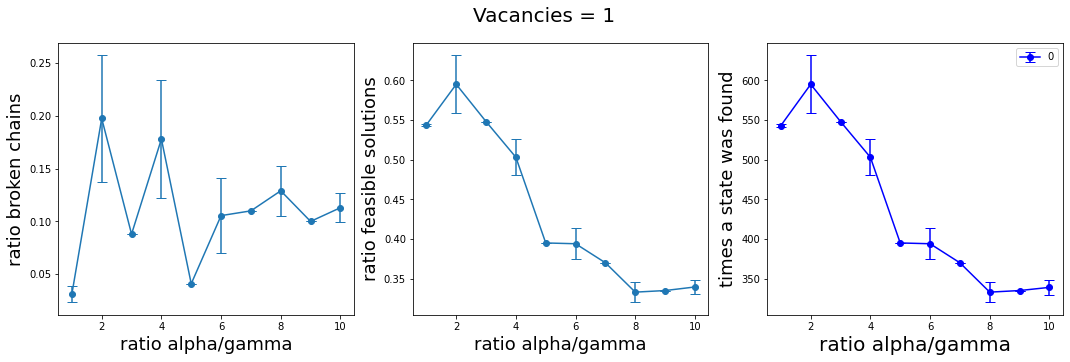

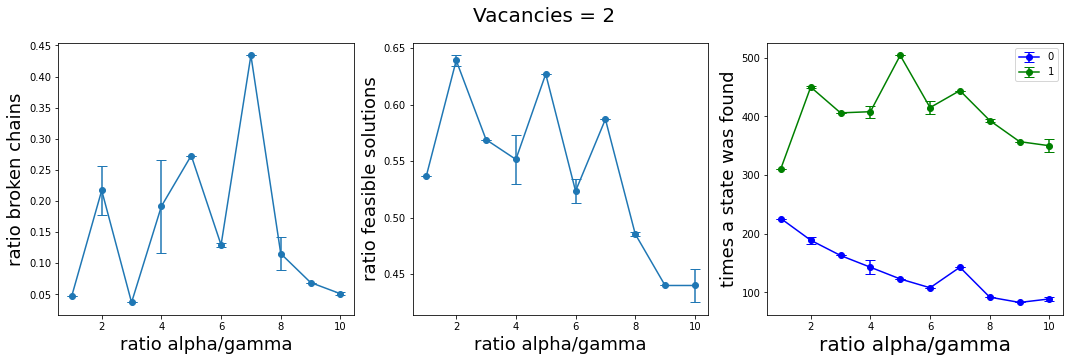

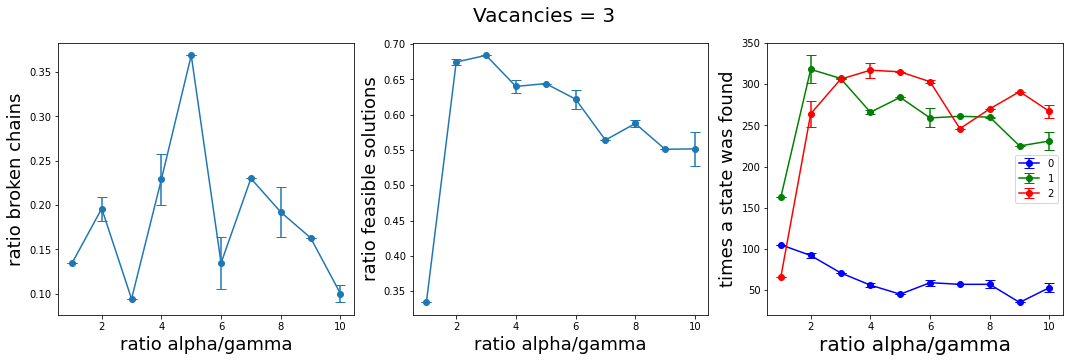

In [488]:
#FEASIBLE
import matplotlib.pyplot as plt

color = ['b','g','r','c','m','y','k','tab:orange']
point = ['-o','^','s']


for vac in [1,2,3]:
    df_all = df_results[df_results['num_vacancies'] == vac]
    df_all = df_all[df_all['weight_1'] == 10]
    df_mean = df_all[df_all['weight_1'] == 10].groupby('ratio l/w').mean()
    fig, axs = plt.subplots(1,3,figsize=(18, 5), sharey=False)
    fig.suptitle('Vacancies = %s'%vac, fontsize=20)
    
    x = df_mean.index.values

    y1 = df_mean['broken_chains'].to_numpy()
    y2 = df_mean['ratio_feasible'].to_numpy()

    y3 = []
    error_y3 = []
    error_bc = []
    error_rf = []
    for n,k in enumerate(x):
        df_tmp = df_all[df_all['ratio l/w'] == k]
        #df_tmp = df_all[df_all['chain_strength'] == k]
        energies = []
        for i in df_all['energy_distribution']:
            energies.extend([float(x) for x in i.split(',')])        
        all_energies = np.unique(np.array(energies))
        labels = [str(x) for x in range(len(all_energies))]
        dist_average = np.array([0]*len(all_energies))
        all_dist = []
        #error_bc.append(np.max(df_tmp['broken_chains'].to_numpy() - np.min(df_tmp['broken_chains'].to_numpy()))
        #error_rf.append(np.max(df_tmp['ratio_feasible'].to_numpy()) - np.min(df_tmp['ratio_feasible'].to_numpy()))
        error_bc.append(np.std(df_tmp['broken_chains'].to_numpy()))
        error_rf.append(np.std(df_tmp['ratio_feasible'].to_numpy()))
        for j in range(len(df_tmp['energy_distribution'].to_list())):
            distribution = []
            error = []
            for i in all_energies:
                v_energy = np.array([float(x) for x in df_tmp['energy_distribution'].to_list()[j].split(',')])
                v_mult = np.array([float(x) for x in df_tmp['multiplicity'].to_list()[j].split(',')])
                pos = np.where(np.round(v_energy,5) == np.round(i,5))[0]
                if len(pos) > 0:
                    distribution.append(int(v_mult[pos[0]]))
                else:
                    distribution.append(0)
            all_dist.append(distribution) 
        y3.append(np.average(np.array(all_dist),axis=0).astype(int).tolist())
        #error_y3.append(np.max(all_dist,axis=0)-np.min(all_dist,axis=0))
        error_y3.append(np.std(all_dist,axis=0))
        #print(y3,np.max(all_dist,axis=0)-np.min(all_dist,axis=0),np.max(all_dist,axis=0),np.min(all_dist,axis=0))
    y3 = np.array(y3)
    error_y3 = np.array(error_y3)
    for m in range(len(y3[0])):
        axs[2].errorbar(x,y3[:,m],yerr=error_y3[:,m]/2,fmt='-o',color=color[m],label=labels[m],capsize=5)

    axs[2].legend()

    #axs[0].plot(x, y1,'-o')
    axs[0].errorbar(x, y1, yerr = np.array(error_bc)/2,fmt='-o',capsize=5)
    axs[1].errorbar(x, y2,yerr = np.array(error_rf)/2,fmt='-o',capsize=5)


    axs[0].set_xlabel('ratio gamma/alpha', fontsize=18)
    axs[1].set_xlabel('ratio gamma/alpha', fontsize=18)
    axs[2].set_xlabel('ratio gamma/alpha', fontsize=20)
    axs[0].set_ylabel('ratio broken chains', fontsize=18)
    axs[1].set_ylabel('ratio feasible solutions', fontsize=18)
    axs[2].set_ylabel('times a state was found', fontsize=18)
#fig.set_title('All feasible',fontsize=20)

#axs[:].set_xticks(np.arange(0,25))
#ax.set_yticks(np.arange(-50,0,5))
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=16)

#fig.set_size_inches(15.5, 7.5)

plt.show()

### chain strength

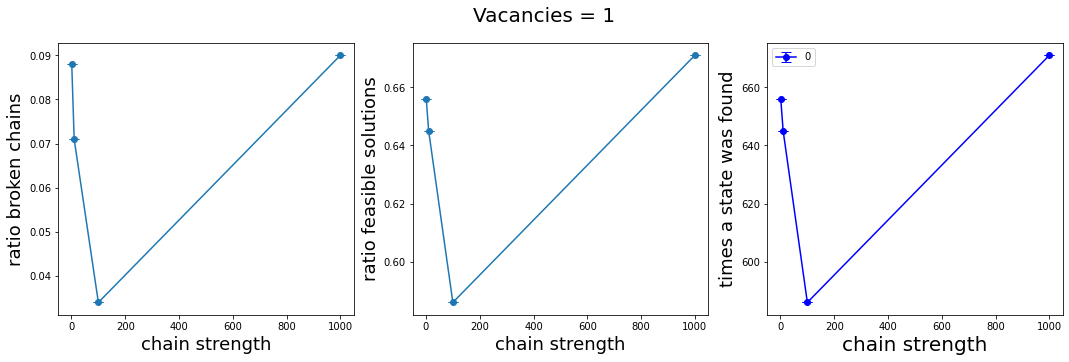

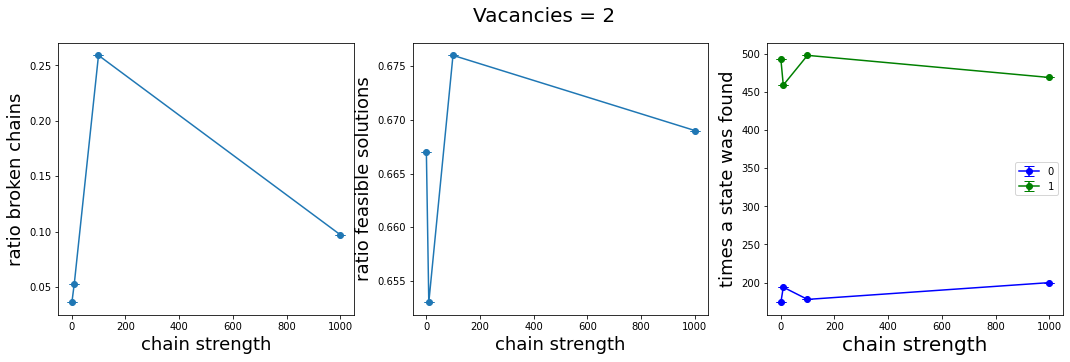

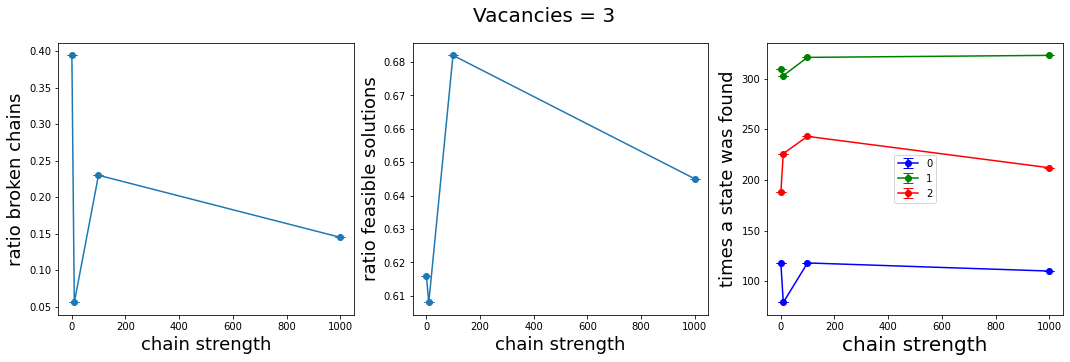

In [505]:
#FEASIBLE
import matplotlib.pyplot as plt

color = ['b','g','r','c','m','y','k','tab:orange']
point = ['-o','^','s']


for vac in [1,2,3]:
    df_all = df_results[df_results['num_vacancies'] == vac]
    df_all = df_all[df_all['weight_1'] == 1]
    df_mean = df_all[df_all['weight_1'] == 1].groupby('chain_strength').mean()
    fig, axs = plt.subplots(1,3,figsize=(18, 5), sharey=False)
    fig.suptitle('Vacancies = %s'%vac, fontsize=20)
    
    x = df_mean.index.values

    y1 = df_mean['broken_chains'].to_numpy()
    y2 = df_mean['ratio_feasible'].to_numpy()

    y3 = []
    error_y3 = []
    error_bc = []
    error_rf = []
    for n,k in enumerate(x):
        df_tmp = df_all[df_all['chain_strength'] == k]
        #df_tmp = df_all[df_all['chain_strength'] == k]
        energies = []
        for i in df_all['energy_distribution']:
            energies.extend([float(x) for x in i.split(',')])        
        all_energies = np.unique(np.array(energies))
        labels = [str(x) for x in range(len(all_energies))]
        dist_average = np.array([0]*len(all_energies))
        all_dist = []
        #error_bc.append(np.max(df_tmp['broken_chains'].to_numpy() - np.min(df_tmp['broken_chains'].to_numpy()))
        #error_rf.append(np.max(df_tmp['ratio_feasible'].to_numpy()) - np.min(df_tmp['ratio_feasible'].to_numpy()))
        error_bc.append(np.std(df_tmp['broken_chains'].to_numpy()))
        error_rf.append(np.std(df_tmp['ratio_feasible'].to_numpy()))
        for j in range(len(df_tmp['energy_distribution'].to_list())):
            distribution = []
            error = []
            for i in all_energies:
                v_energy = np.array([float(x) for x in df_tmp['energy_distribution'].to_list()[j].split(',')])
                v_mult = np.array([float(x) for x in df_tmp['multiplicity'].to_list()[j].split(',')])
                pos = np.where(np.round(v_energy,5) == np.round(i,5))[0]
                if len(pos) > 0:
                    distribution.append(int(v_mult[pos[0]]))
                else:
                    distribution.append(0)
            all_dist.append(distribution) 
        y3.append(np.average(np.array(all_dist),axis=0).astype(int).tolist())
        #error_y3.append(np.max(all_dist,axis=0)-np.min(all_dist,axis=0))
        error_y3.append(np.std(all_dist,axis=0))
        #print(y3,np.max(all_dist,axis=0)-np.min(all_dist,axis=0),np.max(all_dist,axis=0),np.min(all_dist,axis=0))
    y3 = np.array(y3)
    error_y3 = np.array(error_y3)
    for m in range(len(y3[0])):
        axs[2].errorbar(x,y3[:,m],yerr=error_y3[:,m]/2,fmt='-o',color=color[m],label=labels[m],capsize=5)

    axs[2].legend()

    #axs[0].plot(x, y1,'-o')
    axs[0].errorbar(x, y1, yerr = np.array(error_bc)/2,fmt='-o',capsize=5)
    axs[1].errorbar(x, y2,yerr = np.array(error_rf)/2,fmt='-o',capsize=5)


    axs[0].set_xlabel('chain strength', fontsize=18)
    axs[1].set_xlabel('chain strength', fontsize=18)
    axs[2].set_xlabel('chain strength', fontsize=20)
    axs[0].set_ylabel('ratio broken chains', fontsize=18)
    axs[1].set_ylabel('ratio feasible solutions', fontsize=18)
    axs[2].set_ylabel('times a state was found', fontsize=18)
#fig.set_title('All feasible',fontsize=20)

#axs[:].set_xticks(np.arange(0,25))
#ax.set_yticks(np.arange(-50,0,5))
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=16)

#fig.set_size_inches(15.5, 7.5)

plt.show()

### Broken chains

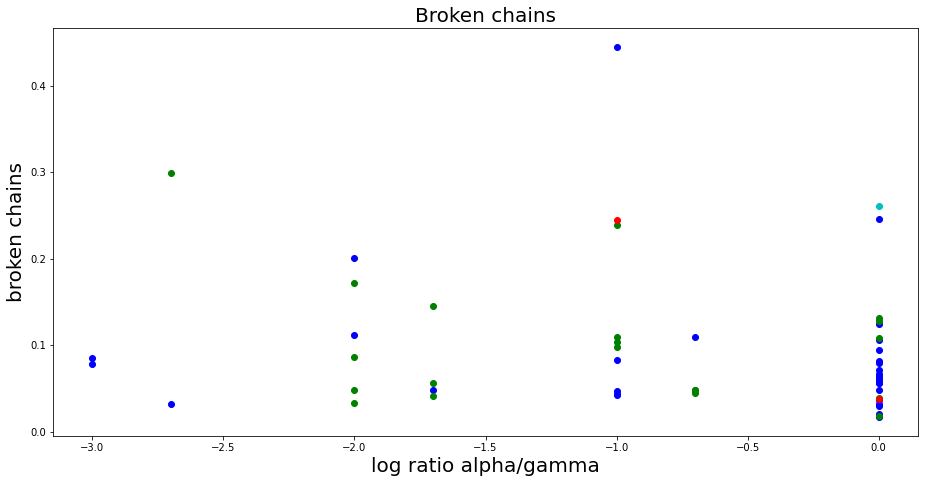

In [67]:
#BROKEN CHAINS
import matplotlib.pyplot as plt

color = ['b','g','r','c','m','y','k','tab:orange']
fig, ax = plt.subplots()

c_code = [int(np.log10(lx)) for lx in ratio_1v_df['weight_1'].to_numpy()]

index = -1

df = ratio_1v_df    

x = df['ratio w/l']
x = [np.log10(lx) for lx in x.to_numpy()]
y = df['broken_chains']

for i in range(len(x)):
    ax.plot(x[i],y[i],'o', color=color[c_code[i]])

ax.set_xlabel('log ratio alpha/gamma', fontsize=20)
ax.set_ylabel('broken chains', fontsize=20) 
ax.set_ybound()
ax.set_title('Broken chains',fontsize=20)

#ax.set_xticks(np.arange(0,18))
#ax.set_yticks(np.arange(-50,0,5))
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=16)

fig.set_size_inches(15.5, 7.5)

plt.show()

# Chain strength

### All feasible

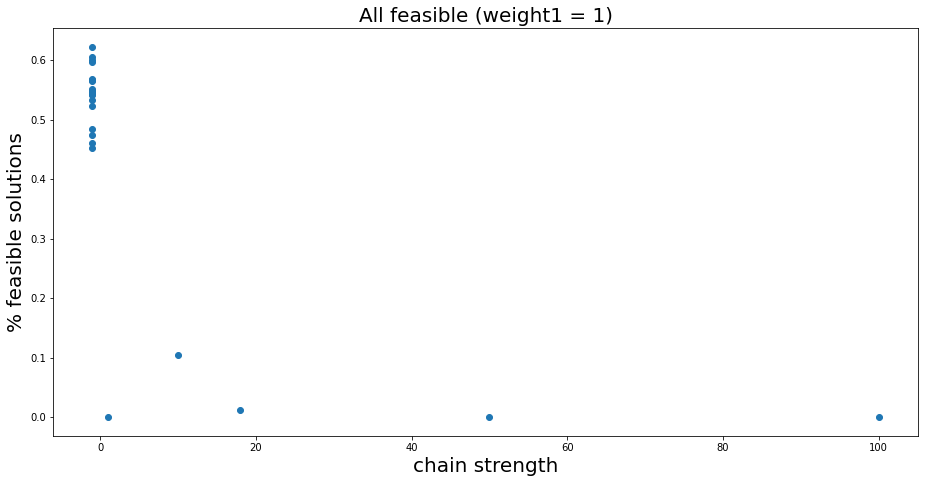

In [112]:
#FEASIBLE
import matplotlib.pyplot as plt

color = ['b','g','r','c','m','y','k','tab:orange']
fig, ax = plt.subplots()

c_code = [int(np.log10(lx)) for lx in ratio_1v_df['weight_1'].to_numpy()]

index = -1

df = ratio_cs_1v_df    

x = df['chain_strength'][:-1]
#x = [np.log10(lx) for lx in x.to_numpy()]
y = df['ratio_feasible'][:-1]


ax.plot(x,y,'o', )

ax.set_xlabel('chain strength', fontsize=20)
ax.set_ylabel('% feasible solutions', fontsize=20) 
ax.set_ybound()
ax.set_title('All feasible (weight1 = 1)',fontsize=20)

#ax.set_xticks(np.arange(0,18))
#ax.set_yticks(np.arange(-50,0,5))
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=16)

fig.set_size_inches(15.5, 7.5)

plt.show()

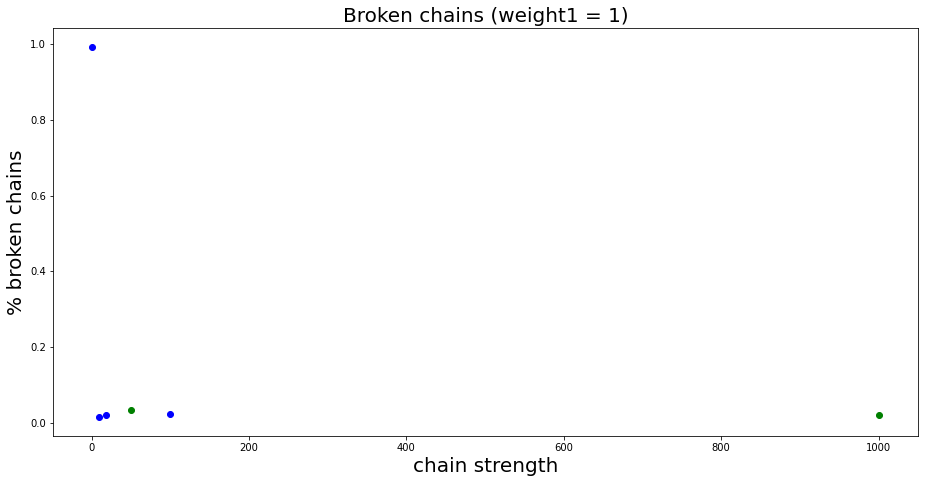

In [95]:
#BROKEN CHAINS
import matplotlib.pyplot as plt

color = ['b','g','r','c','m','y','k','tab:orange']
fig, ax = plt.subplots()

c_code = [int(np.log10(lx)) for lx in ratio_1v_df['weight_1'].to_numpy()]

index = -1

df = ratio_cs_1v_df    

x = df['chain_strength']
#x = [np.log10(lx) for lx in x.to_numpy()]
y = df['broken_chains']

for i in range(len(x)):
    ax.plot(x[i],y[i],'o', color=color[c_code[i]])

ax.set_xlabel('chain strength', fontsize=20)
ax.set_ylabel('% broken chains', fontsize=20) 
ax.set_ybound()
ax.set_title('Broken chains (weight1 = 1)',fontsize=20)

#ax.set_xticks(np.arange(0,18))
#ax.set_yticks(np.arange(-50,0,5))
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=16)

fig.set_size_inches(15.5, 7.5)

plt.show()

## Absolute values $\alpha$, $\gamma$

In [17]:
a = df_all[df_all['num_vacancies'] == 1]
aa = a[a['chain_strength'] == -1]
b = aa[aa['weight_2'] == 0.]
ratio_av_1v_df = b[b['ratio w/l'] == 1].sort_values(by='weight_1')
#ratio_cs_1v_df = b.sort_values(by='chain_strength')
ratio_av_1v_df

,N atoms,num_vacancies,weight_1,weight_2,lagrange,ratio w/l,num_reads,broken_chains,ratio_feasible,energy_distribution,multiplicity,chain_strength
Values,18,1,1,0,1,1.0,1000,0.049,0.549,-24.0,549,-1
Values,18,1,1,0,1,1.0,1000,0.095,0.547,-24.0,547,-1
Values,18,1,1,0,1,1.0,1000,0.030,0.565,-24.0,565,-1
Values,18,1,1,0,1,1.0,1000,0.067,0.567,-24.0,567,-1
Values,18,1,1,0,1,1.0,1000,0.125,0.523,-24.0,523,-1
Values,18,1,1,0,1,1.0,1000,0.056,0.496,-24.0,496,-1
Values,18,1,1,0,1,1.0,1000,0.072,0.551,-24.0,551,-1
Values,18,1,1,0,1,1.0,1000,0.246,0.452,-24.0,452,-1
Values,18,1,1,0,1,1.0,1000,0.060,0.568,-24.0,568,-1
Values,18,1,1,0,1,1.0,1000,0.056,0.600,-24.0,600,-1


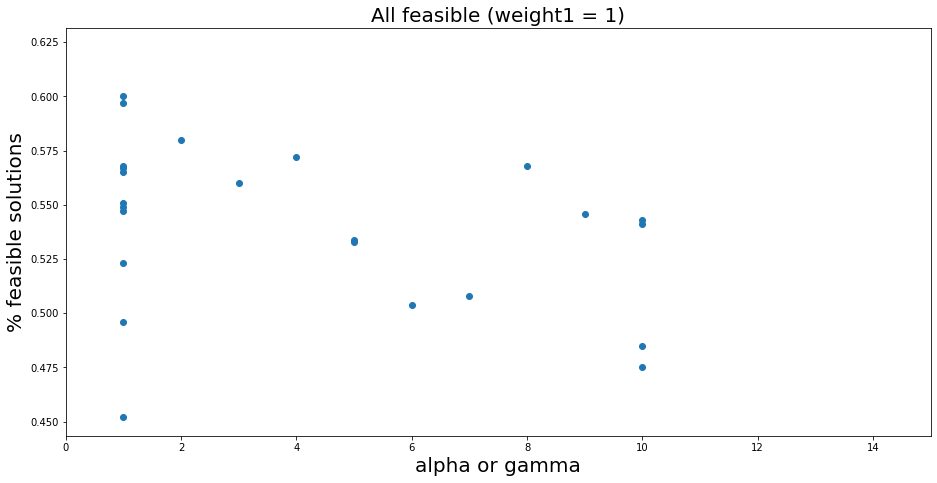

In [27]:
#FEASIBLE
import matplotlib.pyplot as plt

color = ['b','g','r','c','m','y','k','tab:orange']
fig, ax = plt.subplots()

c_code = [int(np.log10(lx)) for lx in ratio_av_1v_df['weight_1'].to_numpy()]

index = -1

df = ratio_av_1v_df    

x = df['weight_1'][:-1]
#x = [np.log10(lx) for lx in x.to_numpy()]
y = df['ratio_feasible'][:-1]


ax.plot(x,y,'o', )

ax.set_xlabel('alpha or gamma', fontsize=20)
ax.set_ylabel('% feasible solutions', fontsize=20) 
ax.set_ybound()
ax.set_xlim([0,15])
ax.set_title('All feasible (weight1 = 1)',fontsize=20)

#ax.set_xticks(np.arange(0,18))
#ax.set_yticks(np.arange(-50,0,5))
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=16)

fig.set_size_inches(15.5, 7.5)

plt.show()

## Symmetry of answer

[0, 2, 5, 8, 13, 14] [1.  0.5 0.5 0.5 0.5 0.5] b
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17] [0.39622642 0.50943396 0.37735849 0.79245283 0.32075472 0.52830189
 0.77358491 0.88679245 0.62264151 0.28301887 0.45283019 0.50943396
 0.58490566 0.49056604 0.9245283  1.         0.69811321 0.77358491] g
[0, 1, 2, 3, 4, 6, 7, 9, 10, 11, 14, 15, 16, 17] [0.14285714 0.42857143 0.57142857 0.42857143 0.42857143 0.42857143
 0.14285714 1.         0.57142857 0.14285714 0.42857143 0.14285714
 0.14285714 0.42857143] r
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17] [0.50181818 0.69636364 0.45636364 0.42909091 0.63454545 0.51636364
 1.         0.41636364 0.32363636 0.49454545 0.50909091 0.54
 0.77454545 0.39272727 0.72363636 0.80363636 0.82545455 0.58363636] c


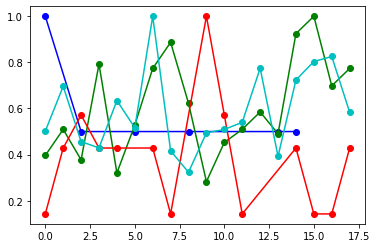

In [63]:
import os

directory = 'data/test_symmetry/'


color = ['b','g','r','c','m','y','k','tab:orange']
fig, ax = plt.subplots()

c_code = [int(np.log10(lx)) for lx in symm_1v_df['weight_1'].to_numpy()]

index = -1

for i,filename in enumerate(os.listdir(directory)):
    f = os.path.join(directory, filename)
    if os.path.isfile(f) and f.endswith(".json") and 'bqm' in f:
        #print(f)
        df, param = load_json(f,return_param = True, return_qubo = False)
        
        x = [x for x in np.where(equivalent_energy_distribution(df,energy=-24)[0] == 0)[1]]
        y = equivalent_energy_distribution(df,energy=-24)[1]/max(equivalent_energy_distribution(df,energy=-24)[1])
        print(x,y,color[i])
        ax.plot(x,y,'-o', color=color[i])

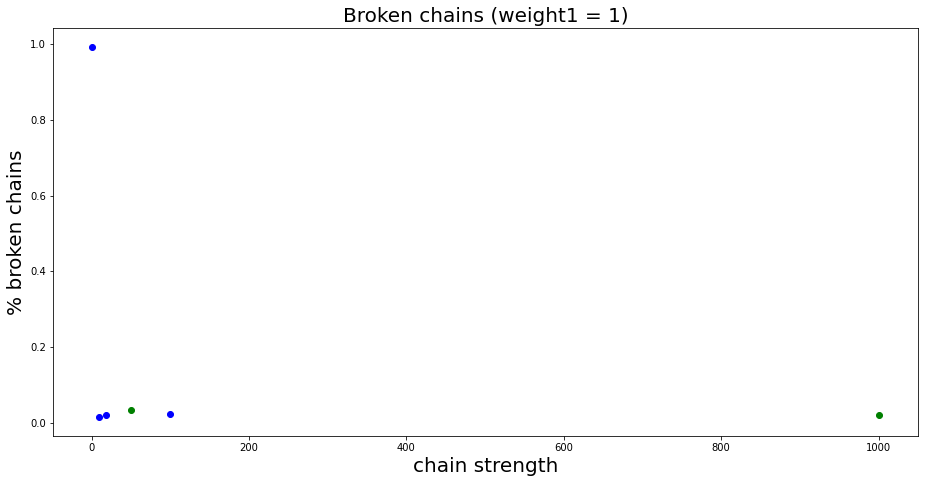

In [95]:
#BROKEN CHAINS
import matplotlib.pyplot as plt

color = ['b','g','r','c','m','y','k','tab:orange']
fig, ax = plt.subplots()

c_code = [int(np.log10(lx)) for lx in symm_1v_df['weight_1'].to_numpy()]

index = -1

df = symm_1v_df    

x = df['chain_strength']
#x = [np.log10(lx) for lx in x.to_numpy()]
y = df['broken_chains']

for i in range(len(x)):
    ax.plot(x[i],y[i],'o', color=color[c_code[i]])

ax.set_xlabel('chain strength', fontsize=20)
ax.set_ylabel('% broken chains', fontsize=20) 
ax.set_ybound()
ax.set_title('Broken chains (weight1 = 1)',fontsize=20)

#ax.set_xticks(np.arange(0,18))
#ax.set_yticks(np.arange(-50,0,5))
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=16)

fig.set_size_inches(15.5, 7.5)

plt.show()

In [53]:
ratio_feasible(a,num_vacancies=1,remove_broken_chains=False)

0.183

[]


TypeError: tuple indices must be integers or slices, not str

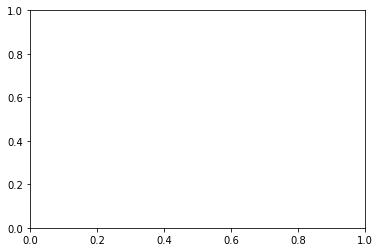

In [291]:
import matplotlib.pyplot as plt

color = ['b','g','r','c','m','y','k','tab:orange']
fig, ax = plt.subplots()
    
index = -1
directory = './data/symmetry/'
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):# and f.endswith(".json"):
        run = int(f[53:-19])
        df = load_json(f)
        index += 1
        
        config, multiplicity = equivalent_energy_distribution(df[0],energy=-24.)
        print(config)
        x = df['lagrange']
        x = [np.log10(lx) for lx in x.to_numpy()]
        y = df['ratio_feasible']

        ax.plot(x,y,'o', color=color[index])

ax.set_xlabel('Lagrange (log)', fontsize=20)
ax.set_ylabel('% feasible solutions', fontsize=20) 
ax.set_ybound()

#ax.set_xticks(np.arange(0,18))
#ax.set_yticks(np.arange(-50,0,5))
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=16)

fig.set_size_inches(18.5, 10.5)

plt.show()

In [274]:
directory = './data/symmetry/'
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):# and f.endswith(".json"):
        print(f[53:-19])

2500
500
2000
100
1500
1000


In [ ]:
config_all, energy_all, multiplicity_all = find_all_structures(dataframe, sort_config=True)

In [ ]:
np.sum(multiplicity_all)

## Chain strength

## Exact solver

In [15]:
import os

directory = 'data/test/'

dataframes = []

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f) and f.endswith(".json") and 'bqm' in f:
        #print(f)
        df, param = load_json(f,return_param = True, return_qubo = False)
        if np.sum(df['chain_break_fraction']==0.) > 0:
            param = param.transpose()
            n_vac = param['num_vacancies'].values[0]
            n_atoms = param['N atoms'].values[0]
            param['broken_chains'] = find_ratio_broken_chains(df)
            #param['ratio_feasible'] = ratio_feasible(df,param['num_vacancies'].values[0],remove_broken_chains=False)   
            param['ratio_feasible_nb'] = find_ratio_feasible(df,param['num_vacancies'].values[0], remove_broken_chains=True)   
            param['ratio_feasible'] = find_ratio_feasible(df,param['num_vacancies'].values[0], remove_broken_chains=False)
            param['energy_distribution_all'] = ', '.join(str(x) for x in find_energy_distribution(df)[0])
            param['multiplicity_all'] = ', '.join(str(x) for x in find_energy_distribution(df)[1])        
            param['energy_distribution'] = ', '.join(str(x) for x in find_energy_distribution(df, only_feasible=True, vacancies=param['num_vacancies'].values[0])[0])
            #param['num_broken_bonds'] = ', '.join(str(x) for x in calc_num_broken_bonds(dataframe, remove_broken_chains = True, only_feasible = True, vacancies = param['num_vacancies'].values[0]))
            param['multiplicity'] = ', '.join(str(x) for x in find_energy_distribution(df, only_feasible=True, vacancies=param['num_vacancies'].values[0])[1])
            param['ratio w/l'] = param['weight_1'] / param['lagrange']
            #print(energy_distribution(df, only_feasible=True, vacancies=n_vac))
            '''if energy_distribution(df, only_feasible=True, vacancies=n_vac)[0][0] == -(-1 - n_vac*2+n_atoms*1.5):
                param['min_found'] = True
            else:
                param['min_found'] = False'''
            if 'chain_strength' not in param:
                param['chain_strength'] = -1
            #print(param['chain_strength'])
            if param['chain_strength'].all() == None:
                param['chain_strength'] = -1
                print('YES')
            dataframes.append(param)
        else:
            print('Broken: ',f)
df_results = pd.concat(dataframes)